In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')
data_path = '/content/drive/MyDrive/GD-CV/GD_05'

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs', data_dir = data_path,
    split = ['train','test'],
    shuffle_files = True,
    with_info = True,
    download = False
)

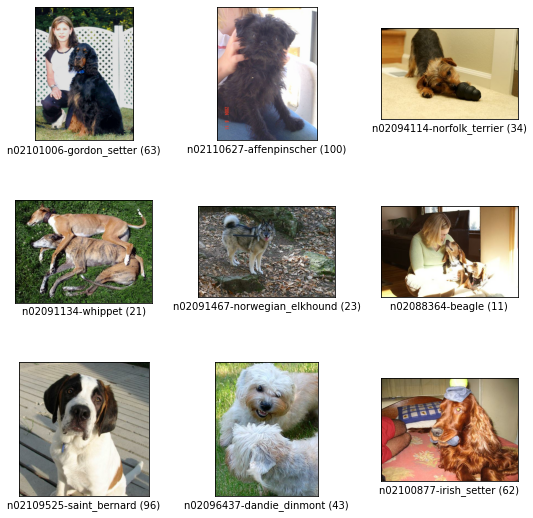

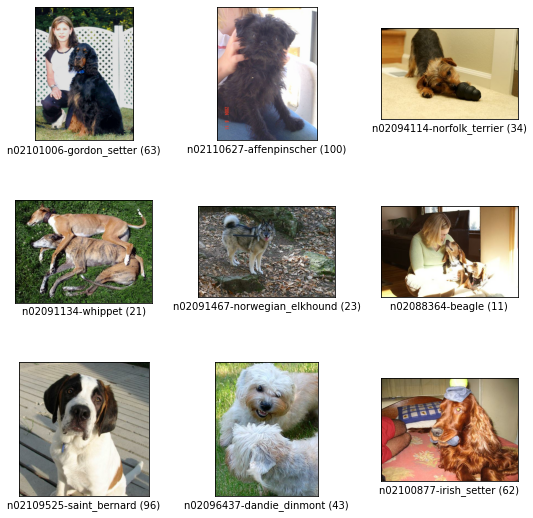

In [4]:
tfds.show_examples(ds_train, ds_info)

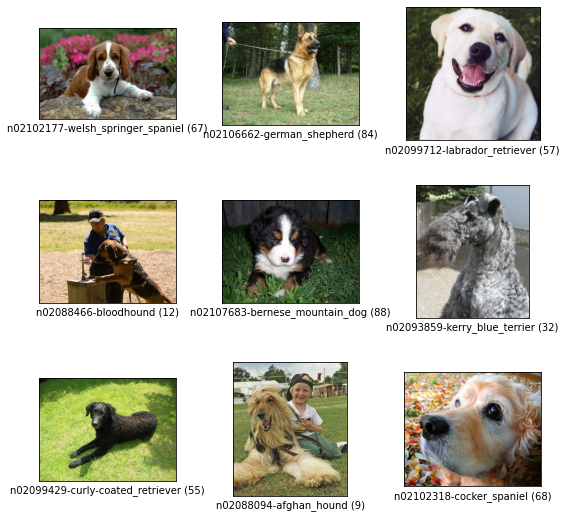

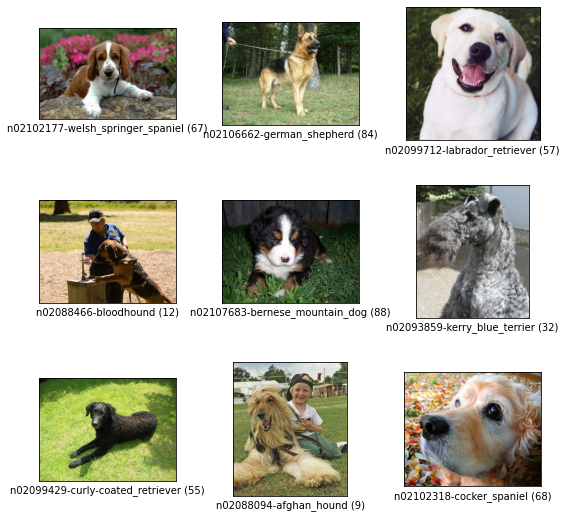

In [ ]:
tfds.show_examples(ds_test, ds_info)

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [ ]:
label_names =ds_info.features['label']
label_names

ClassLabel(shape=(), dtype=tf.int64, num_classes=120)

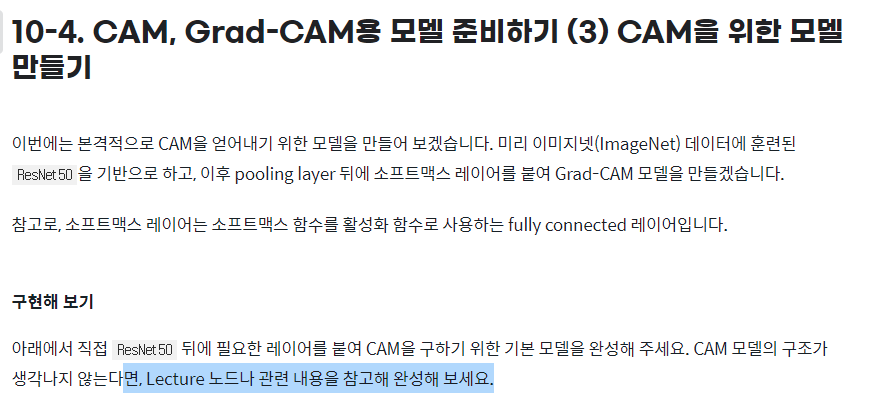

In [5]:
num_classes = ds_info.features['label'].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top = False, # Imagenet 분류기 fully connested layer 제거 해야함
    weights='imagenet',
    input_shape = (224,224,3),
    pooling = 'avg'
)

x = base_model.output
# x 는 avg pooling이 끝난 이후 classification 처리가 되어야 함
# 따라서 Dense Layer with softmax

preds = keras.layers.Dense(num_classes,activation='softmax')(x)

cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [6]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
def normalize_and_resize_img(input):
    # Normalizes Images : 'uint8' -> 'float32'
    # input shape  =[224,224,3]
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test =False, batch_size = 16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls =2
    )
    ds = ds.batch(batch_size)
    # training 일 때 
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치 모양 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [9]:
cam_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),
    metrics = ['accuracy'],
)

In [ ]:
# history_cam_model = cam_model.fit(
#     ds_train_norm,
#     # num_examples/ batch_size
#     steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
#     validation_steps = int(ds_info.splits['test'].num_examples/16),
#     epochs = 10,
#     validation_data = ds_test_norm,
#     verbose = 1,
#     use_multiprocessing = True,
# )

Epoch 1/10
750/750 [==============================] - 108s 129ms/step - loss: 2.1954 - accuracy: 0.0085 - val_loss: 3.4295 - val_accuracy: 0.0033
Epoch 2/10
750/750 [==============================] - 95s 126ms/step - loss: 0.7018 - accuracy: 0.0090 - val_loss: 1.0504 - val_accuracy: 0.0101
Epoch 3/10
750/750 [==============================] - 94s 126ms/step - loss: 0.2108 - accuracy: 0.0075 - val_loss: 0.9292 - val_accuracy: 0.0061
Epoch 4/10
750/750 [==============================] - 94s 126ms/step - loss: 0.0503 - accuracy: 0.0088 - val_loss: 0.8952 - val_accuracy: 0.0066
Epoch 5/10
750/750 [==============================] - 95s 126ms/step - loss: 0.0217 - accuracy: 0.0081 - val_loss: 0.9143 - val_accuracy: 0.0065
Epoch 6/10
750/750 [==============================] - 98s 131ms/step - loss: 0.0135 - accuracy: 0.0082 - val_loss: 0.9358 - val_accuracy: 0.0070
Epoch 7/10
750/750 [==============================] - 95s 127ms/step - loss: 0.0114 - accuracy: 0.0082 - val_loss: 0.9469 - val_a

In [ ]:
# import os

# cam_model_path =  '/content/drive/MyDrive/GD-CV/GD_05'
# cam_model.save(cam_model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GD-CV/GD_05/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GD-CV/GD_05/assets


In [10]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    # sample_Data 는 len = 1인 리스트이며 
    # sample_Data[0] 자료형은 Dict 
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0] 

In [ ]:
sample_exp = ds_test.take(1)
sample_exp

<TakeDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)}}>

In [ ]:
sample_data_exp = list(sample_exp.as_numpy_iterator())
sample_data_exp

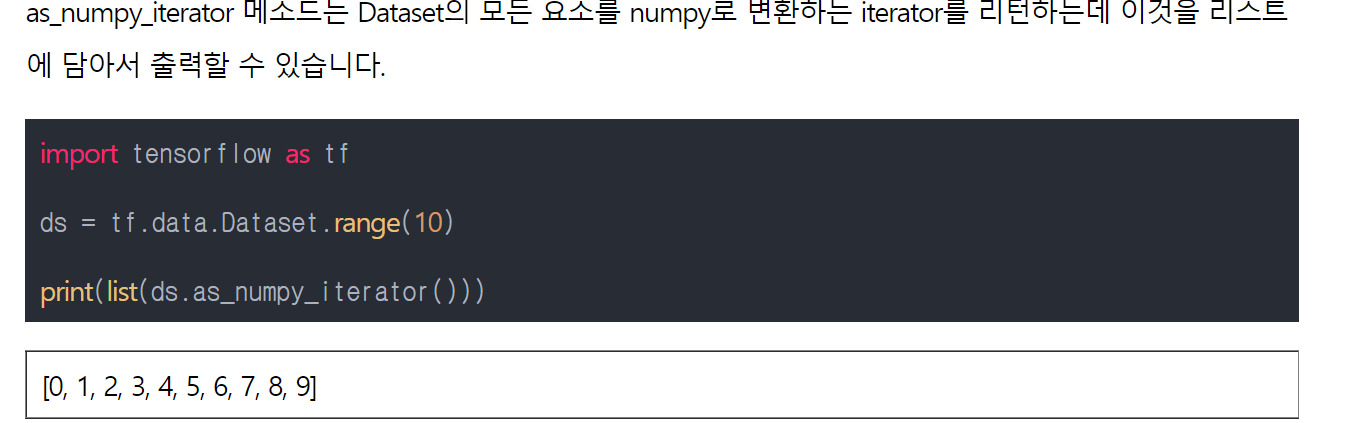

In [ ]:
np_data = sample_data_exp[0]

In [ ]:
type(np_data)

dict

In [ ]:
for i in np_data.keys():
    print(i)

image
image/filename
label
objects


In [ ]:
for i in np_data.keys():
    print(np_data[i])

[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [ 19  19  29]
  [ 20  20  30]
  [ 20  20  30]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [ 22  22  32]
  [ 22  22  32]
  [ 23  23  33]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [ 20  20  28]
  [ 20  20  28]
  [ 21  21  29]]

 ...

 [[242 238 252]
  [239 235 249]
  [239 236 247]
  ...
  [226 212 235]
  [225 211 234]
  [223 209 232]]

 [[248 244 255]
  [240 236 250]
  [237 234 245]
  ...
  [223 210 228]
  [222 209 229]
  [221 208 226]]

 [[250 246 255]
  [242 238 252]
  [239 236 247]
  ...
  [222 209 226]
  [220 207 225]
  [219 206 223]]]
b'Images/n02112137-chow/n02112137_11830.jpg'
108
{'bbox': array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)}


In [ ]:
image_f =np_data['image']
type(image_f)

numpy.ndarray

In [ ]:
# 이미지 (픽셀) 크기, 채널
image_f.shape

(375, 500, 3)

np_data['objects']는 이중 딕셔너리 형태임.

Object 안에 bbox 키가 더 있음

In [ ]:
np_data['objects'].keys()

dict_keys(['bbox'])

In [ ]:
np_data['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

In [ ]:
print(sample_data_exp)

[{'image': array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [ 19,  19,  29],
        [ 20,  20,  30],
        [ 20,  20,  30]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [ 22,  22,  32],
        [ 22,  22,  32],
        [ 23,  23,  33]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [ 20,  20,  28],
        [ 20,  20,  28],
        [ 21,  21,  29]],

       ...,

       [[242, 238, 252],
        [239, 235, 249],
        [239, 236, 247],
        ...,
        [226, 212, 235],
        [225, 211, 234],
        [223, 209, 232]],

       [[248, 244, 255],
        [240, 236, 250],
        [237, 234, 245],
        ...,
        [223, 210, 228],
        [222, 209, 229],
        [221, 208, 226]],

       [[250, 246, 255],
        [242, 238, 252],
        [239, 236, 247],
        ...,
        [222, 209, 226],
        [220, 207, 225],
        [219,

40


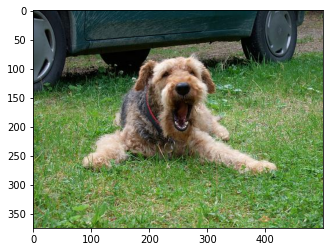

In [ ]:
# item > dataset에서 한 장 가져온 데이터
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [11]:
cam_model_path =  '/content/drive/MyDrive/GD-CV/GD_05'
cam_model = tf.keras.models.load_model(cam_model_path)

In [ ]:
def generate_cam(model,item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)

    # input, output을 새롭게 정의
    # model.layers[-3].output에서는 GAP이전 Conv layer의 Output을 얻을 수 있음
    # 아마 dense > GAP > Feature Map
    # cam_model = tf.keras.models.Model([모델에 들어갈 input],[출력 될 output_list])
    cam_model = tf.keras.models.Model([model.inputs],[model.layers[-3].output,model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor,0))
    conv_outputs = conv_outputs[0,:,:,:]

    # 모델의 weight activation은 마지막 layer에 존재
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape = conv_outputs.shape[0:2])
    for i,w in enumerate(class_weights[:,class_idx]):
        # conv_outputs의 i번쨰 채널과 i번째 weight를 곱해 heatmap 생성
        cam_image += w* conv_outputs[:,:,i]
    # activation score를 normalize
    cam_image /= np.max(cam_image)
    # It converts a tensor object into an numpy.ndarray object.
    # This implicitly means that the converted tensor will be now processed on the CPU.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image,(width,height)) #  원래 이미지 크기로  resize
    return cam_image

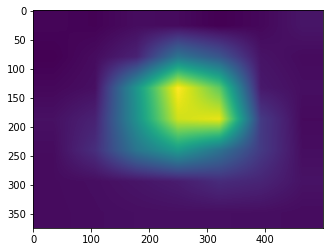

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [ ]:
def visualize_cam_on_image(src1,src2,alpha = 0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1,alpha, src2, beta, 0.0)
    return merged_image

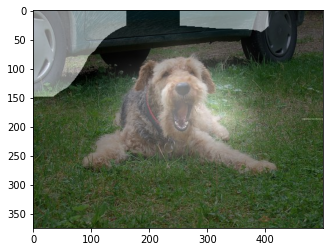

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np. stack([cam_image*255]*3,axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel,origin_image)
plt.imshow(blended_image)
plt.show()

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

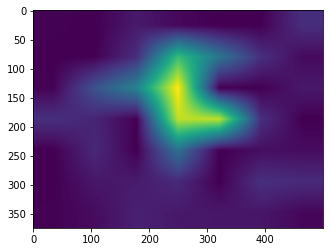

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

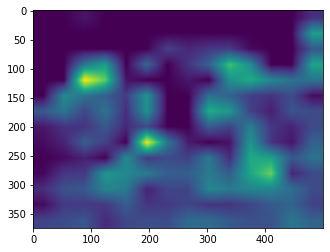

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

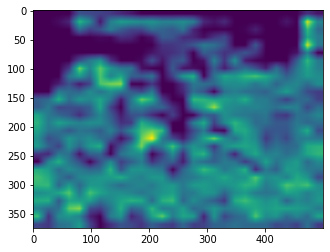

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

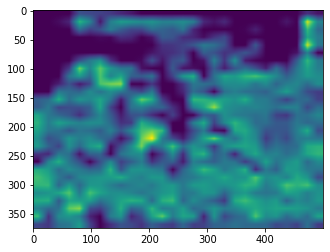

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

67


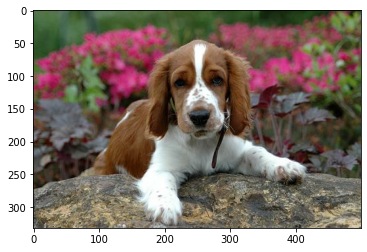

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

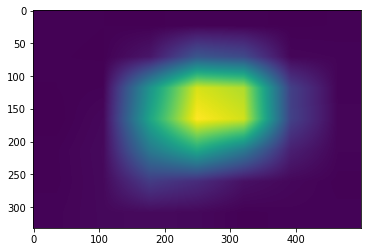

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [ ]:
rect = get_bbox(cam_image)
rect

array([[ 99,  43],
       [438,  17],
       [458, 277],
       [119, 303]])

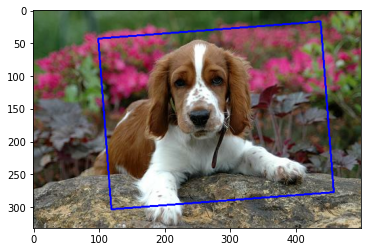

In [ ]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [ ]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.05120481927710843, 0.198, 0.9126506024096386, 0.916]

In [ ]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6872295689363158

# CAM, Grad-CAM 구현

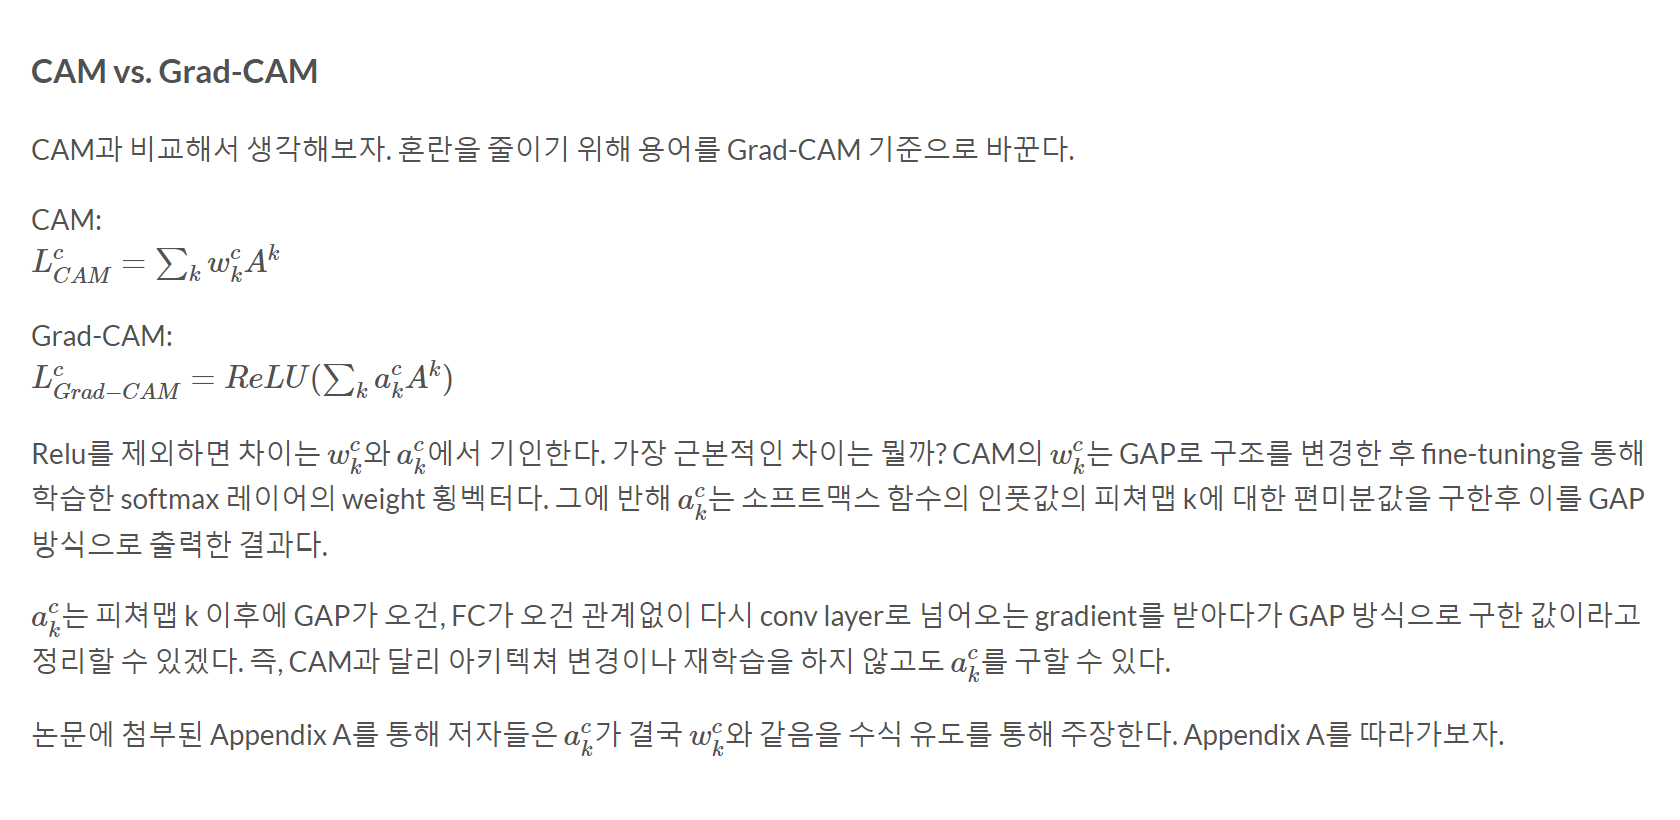

CAM Image 와 Grad - CAM Image를 만드는 함수

---

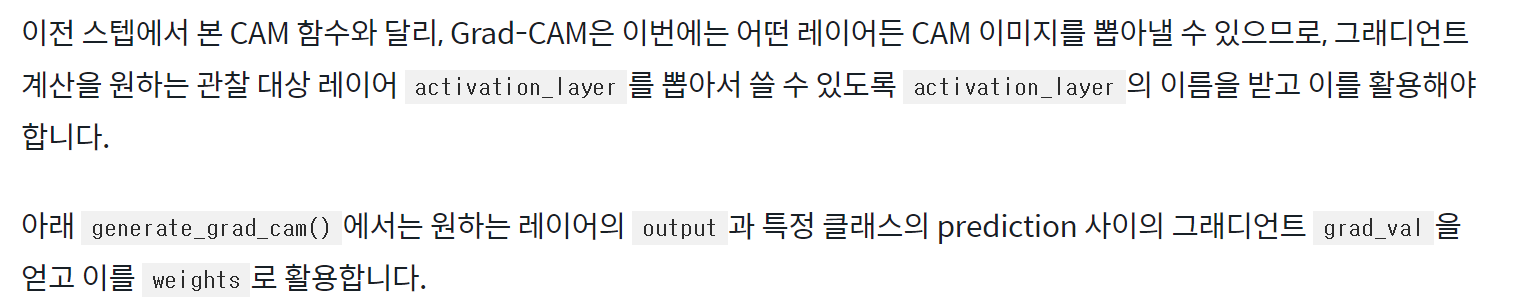

In [12]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    # sample_Data 는 len = 1인 리스트이며 
    # sample_Data[0] 자료형은 Dict 
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0] 

In [13]:
# train dataset에서 10장의 이미지 가져옴
ds_ex = ds_train.take(10)
# ds_ex = list(ds.as_numpy_literator())

In [14]:
def generate_cam(model,item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)

    # input, output을 새롭게 정의
    # model.layers[-3].output에서는 GAP이전 Conv layer의 Output을 얻을 수 있음
    # 아마 dense > GAP > Feature Map
    # cam_model = tf.keras.models.Model([모델에 들어갈 input],[출력 될 output_list])
    
    cam_model = tf.keras.models.Model([model.inputs],[model.layers[-3].output,model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor,0))
    conv_outputs = conv_outputs[0,:,:,:]

    # 모델의 weight activation은 마지막 layer에 존재
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape = conv_outputs.shape[0:2])
    for i,w in enumerate(class_weights[:,class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해 heatmap 생성
        cam_image += w* conv_outputs[:,:,i]
    # activation score를 normalize
    cam_image /= np.max(cam_image)
    # It converts a tensor object into an numpy.ndarray object.
    # This implicitly means that the converted tensor will be now processed on the CPU.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image,(width,height)) #  원래 이미지 크기로  resize
    return cam_image

사용할 데이터

In [ ]:
type(ds_ex)

tensorflow.python.data.ops.dataset_ops.TakeDataset

Take() 메서드로 가져온 데이터 셋은
 
애초에 iterable한 형태로 저장되어 있으나 원하는 위치의 정보를 꺼낼 수는 없음

In [ ]:
for i in ds_ex:
    print(i)

따라서 넘파이 iterator 형태로 데이터를 읽고 이를 리스트로 만들어 원하는 위치의 정보를 꺼내 볼 수있음

In [ ]:
ds_iter = list(ds_ex.as_numpy_iterator())
type(ds_iter[0])

dict

In [ ]:
ds_iter[1]['objects']['bbox']

array([[0.05890227, 0.        , 0.9973226 , 0.87857145]], dtype=float32)

In [ ]:
cam_model_t = keras.models.Model(cam_model.input,[cam_model.layers[-3].output, cam_model.output ] )

In [ ]:
conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor,0))

67


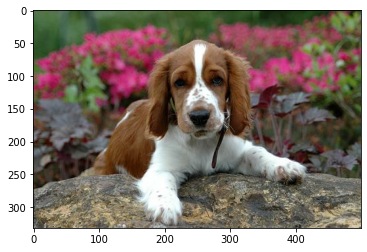

In [16]:
# item > dataset에서 한 장 가져온 데이터
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

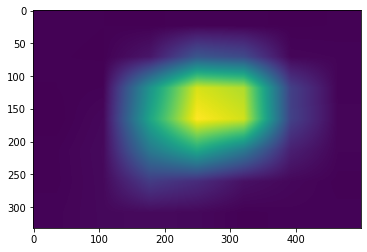

In [17]:
# CAM 이미지 확인
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

https://github.com/stereo-weld/explorations/blob/master/CV10_Project_Class_Activation_Map.ipynb

CAM 이미지와 원본 이미지를 합쳐주는 함수

In [21]:
import cv2
def visualize_cam_on_image(image, cam_image, alpha=0.3):
#     img1 = cv2.imread(image)
#     img2 = cv2.imread(cam_image)

#     # 블렌딩하는 두 이미지의 크기가 같아야함
#     width = img1.shape[1]
#     height = img1.shape[0]
#     img2 = cv2.resize(img2, (width, height))
    
    # image 사진은 점점 투명해지고 cam_image 사진은 점점 불투명해짐
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    
    return merged_image

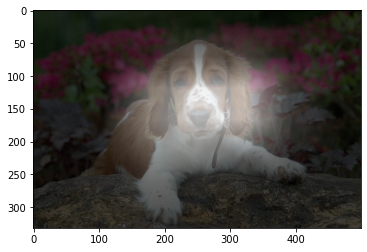

In [23]:
# visualize_cam_on_image() 함수 사용
orig_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(orig_image, cam_image_3channel)
plt.imshow(blended_image)

In [25]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

Grad CAM에서 어떤 레이어를 가져올지 결정해야 하기 때문에 summary()함수로 출력을 확인해본다.

In [ ]:
cam_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Grad-CAM Images

In [56]:
def show_gdcam(model,layer_name,image_input):
    k = generate_grad_cam(model,layer_name,image_input)
    plt.imshow(k)
    return k

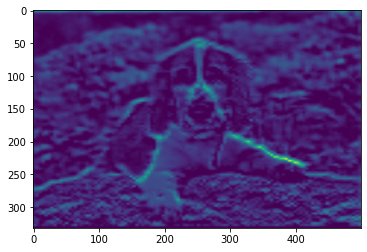

In [59]:
grad_cam_image = show_gdcam(cam_model, 'conv1_conv', item)

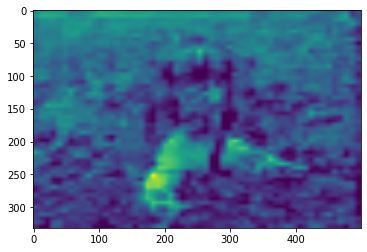

In [60]:
grad_cam_image2 =show_gdcam(cam_model, 'conv2_block1_1_relu', item)

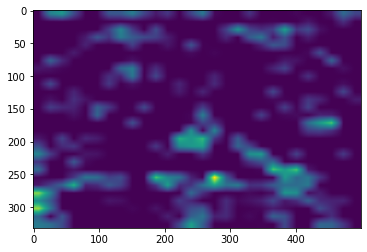

In [61]:
grad_cam_image3 =show_gdcam(cam_model, 'conv3_block1_2_conv', item)

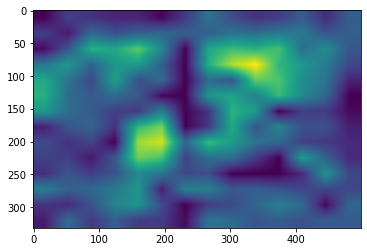

In [62]:
grad_cam_image4 =show_gdcam(cam_model, 'conv4_block4_out', item)

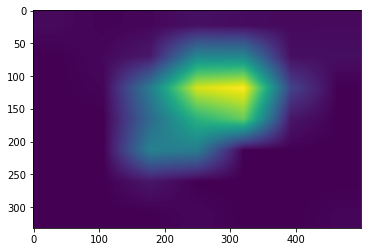

In [63]:
grad_cam_image5 =show_gdcam(cam_model,'conv5_block2_out',item)

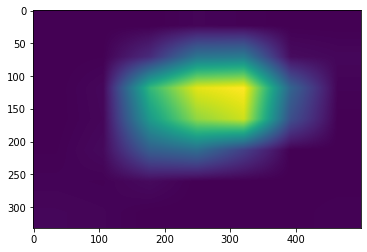

In [64]:
grad_cam_image6 =show_gdcam(cam_model, 'conv5_block3_out', item)

# Blended Grad_CAM Image

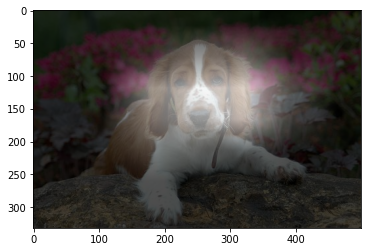

In [66]:
grad_origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image6*255]*3, axis=-1).astype(np.uint8)

grad_blended_image = visualize_cam_on_image(grad_origin_image, grad_cam_image_3channel)
plt.imshow(grad_blended_image)

# BBox

In [45]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [46]:
rect = get_bbox(cam_image)
rect

array([[ 99,  43],
       [438,  17],
       [458, 277],
       [119, 303]])

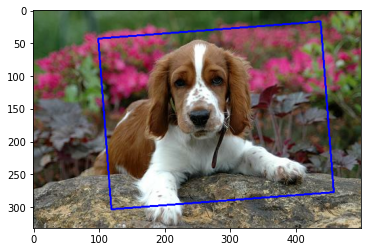

In [52]:
# CAM으로 얻은 바운딩 박스
image = copy.deepcopy(item['image'])
rect_cam = get_bbox(cam_image)

image_cam = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image_cam)

In [73]:
rect_gred_cam = get_bbox(grad_cam_image6)
rect_gred_cam

array([[106,  33],
       [450,  20],
       [458, 245],
       [114, 258]])

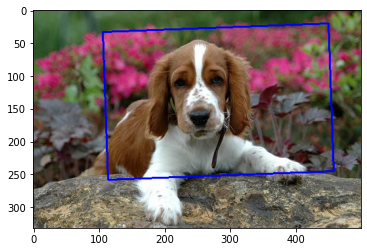

In [74]:
# Grad-CAM으로 얻은 바운딩 박스
image = copy.deepcopy(item['image'])
rect_grad_cam = get_bbox(grad_cam_image6)

image_grad_cam = cv2.drawContours(image, [rect_grad_cam], 0, (0,0,255), 2)
plt.imshow(image_grad_cam)

In [48]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [49]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.05120481927710843, 0.198, 0.9126506024096386, 0.916]

# IOU

In [50]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

참조

https://github.com/stereo-weld/explorations/blob/master/CV10_Project_Class_Activation_Map.ipynb

In [79]:
# CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU
pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])
get_iou(pred_bbox_cam, item['objects']['bbox'][0])

0.6872295689363158

In [80]:
# Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU
pred_bbox_grad_cam = rect_to_minmax(rect_grad_cam, item['image'])
get_iou(pred_bbox_grad_cam, item['objects']['bbox'][0])

0.5705771741402226

Grad CAM으로 얻은 BBox가 더 커서인지 IOU가 조금 더 작게 나왔다.

# 회고

CAM과 Grad-CAM을 사용해 본 결과 성능 면에서는 모르겠지만 내가 원하는 레이어의 Activation map을 볼 수 있다는 점에서 grad cam의 설명력이 더 좋다고 생각한다.

Explainable AI에 대해서는 아직 확신은 없다. 모델의 Activation map을 본다 해도 그것이 정말 설명이 되는 것인지는 모르겠다.

